<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Fri Feb  9 08:02:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   28C    P0              48W / 350W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.5
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q25,q75)
q25_store = np.zeros([t_store.size+1,batch])    
q75_store = np.zeros([t_store.size+1,batch])

q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q25_store[j,:]= np.sum(q1[0:25,:], axis=0)
        q75_store[j,:]= np.sum(q1[0:75,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

1000.0
CPU times: user 9min 7s, sys: 9.49 ms, total: 9min 7s
Wall time: 9min 9s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

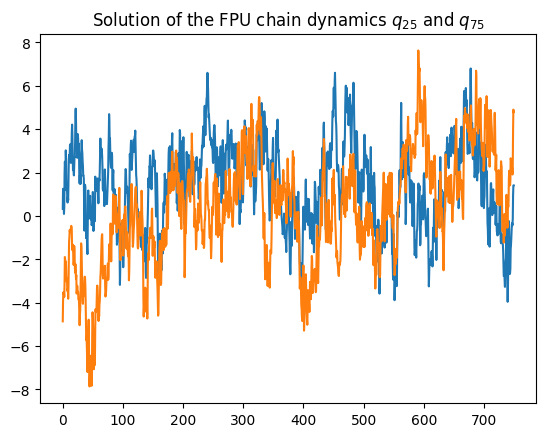

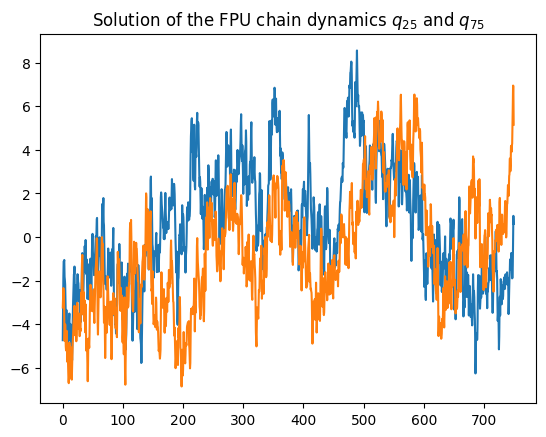

In [9]:
plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


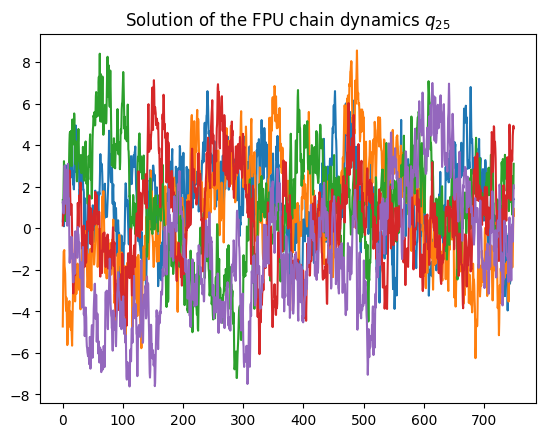

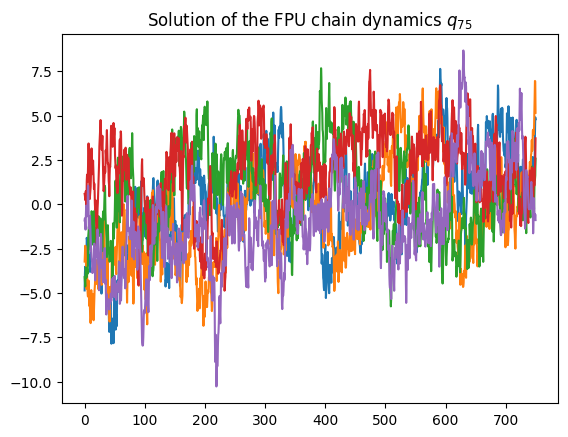

In [10]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [11]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [12]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


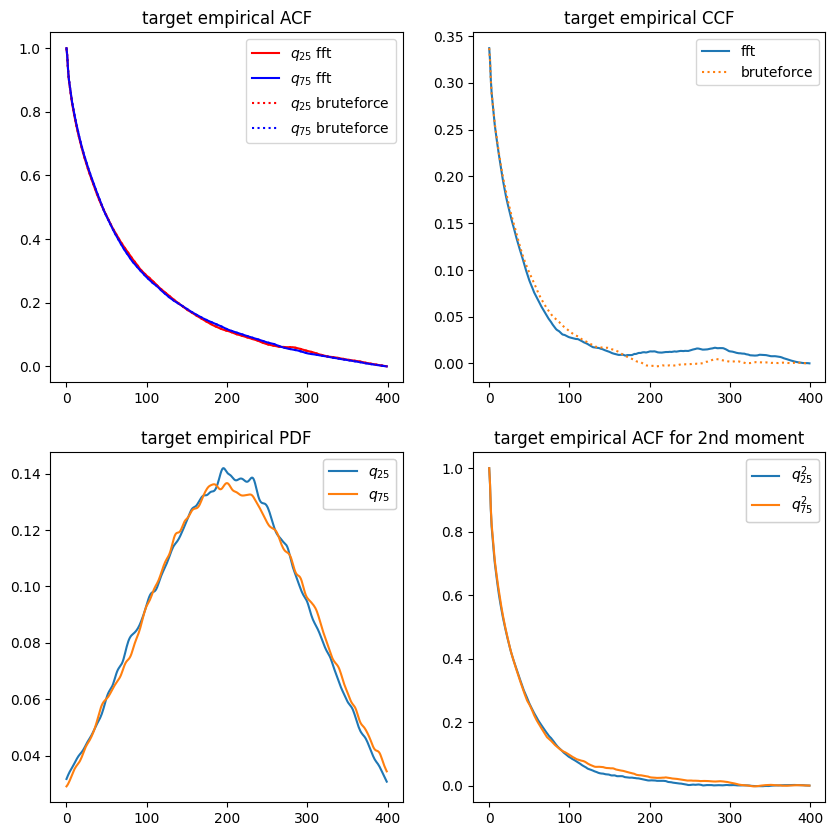

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

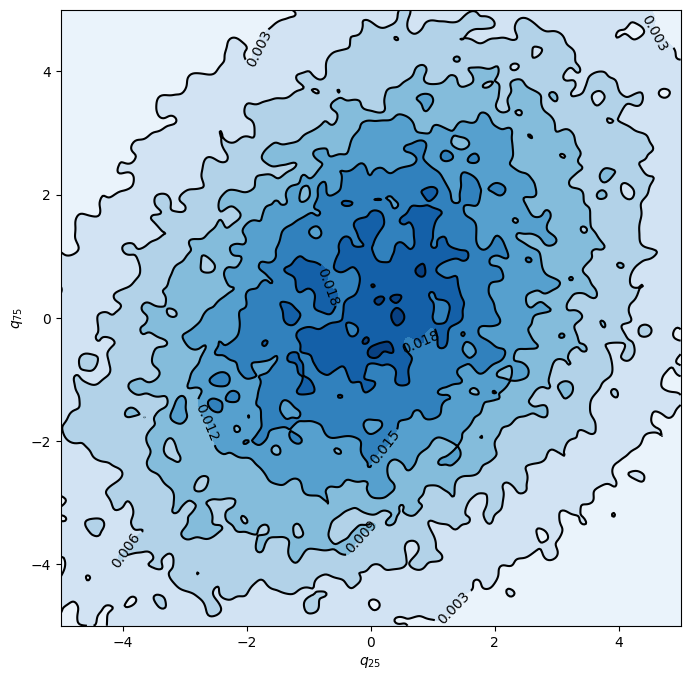

In [14]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

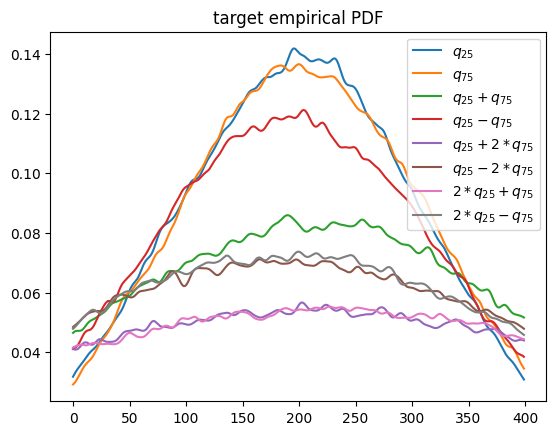

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [17]:
model_type = 1

In [18]:
### Defining SINN model
net = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.6955, 0.6913, acf: 0.07185, ccf: 0.00425, pdf: 0.29111, pdf2: 0.29811, acf2: 0.02604
[50]-th step loss: 0.0897, 0.0918, acf: 0.03887, ccf: 0.01623, pdf: 0.01230, pdf2: 0.01532, acf2: 0.00904
[100]-th step loss: 0.0402, 0.0436, acf: 0.02422, ccf: 0.00935, pdf: 0.00550, pdf2: 0.00355, acf2: 0.00099
[150]-th step loss: 0.1069, 0.0943, acf: 0.04662, ccf: 0.01146, pdf: 0.00742, pdf2: 0.01751, acf2: 0.01130
[200]-th step loss: 0.0470, 0.0454, acf: 0.01242, ccf: 0.02149, pdf: 0.00582, pdf2: 0.00423, acf2: 0.00145
[250]-th step loss: 0.0352, 0.0339, acf: 0.01313, ccf: 0.00852, pdf: 0.00627, pdf2: 0.00150, acf2: 0.00453
[300]-th step loss: 0.0179, 0.0162, acf: 0.00423, ccf: 0.00373, pdf: 0.00440, pdf2: 0.00119, acf2: 0.00261
[350]-th step loss: 0.0087, 0.0097, acf: 0.00226, ccf: 0.00300, pdf: 0.00179, pdf2: 0.00128, acf2: 0.00135
[400]-th step loss: 0.0395, 0.0375, acf: 0.02599, ccf: 0.00211, pdf: 0.00562, pdf2: 0.00316, acf2: 0.00066
[450]-th step loss: 0.0164, 0.0147, acf:

In [19]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [20]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [21]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [22]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

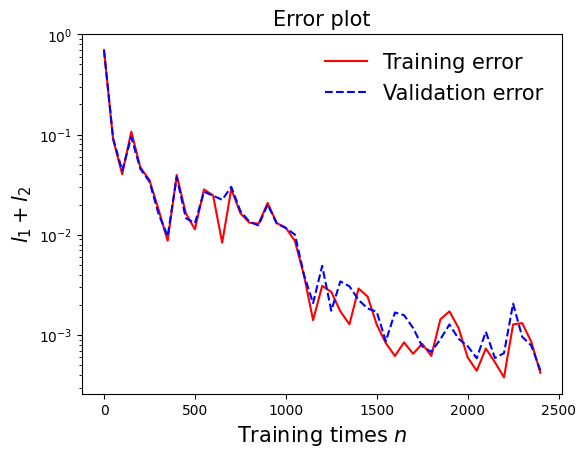

In [23]:
draw_loss(model)

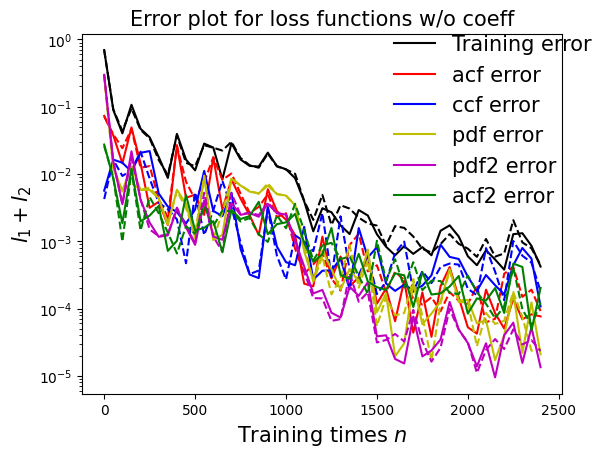

In [24]:
draw_errors(model)

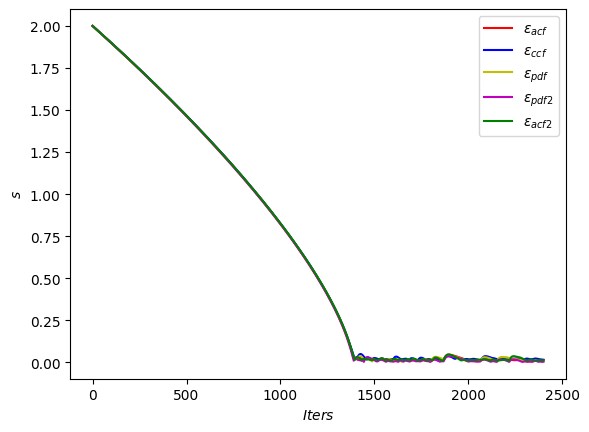

In [25]:
draw_adaptive_w(model)

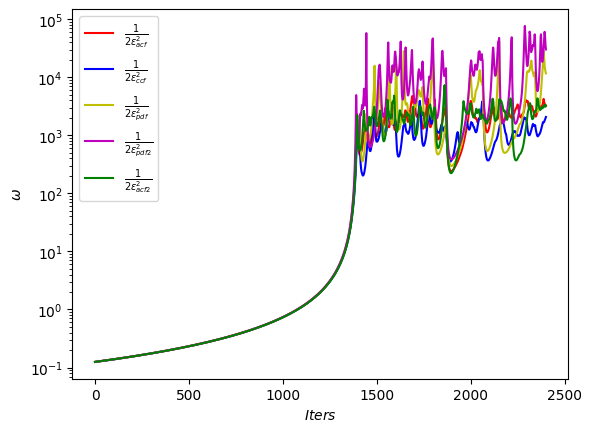

In [26]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [27]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [28]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [29]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [30]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [31]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [32]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [33]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

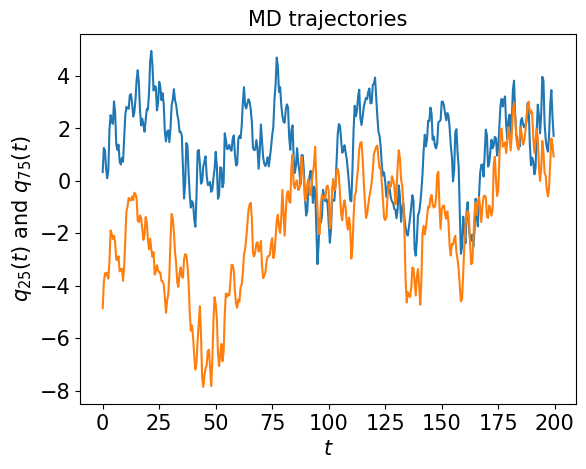

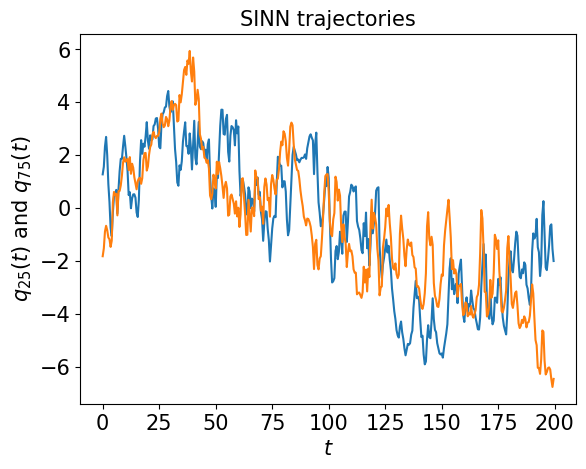

In [34]:
test1(model)

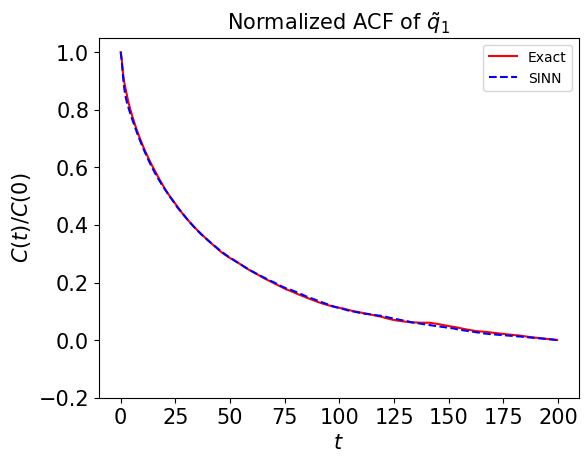

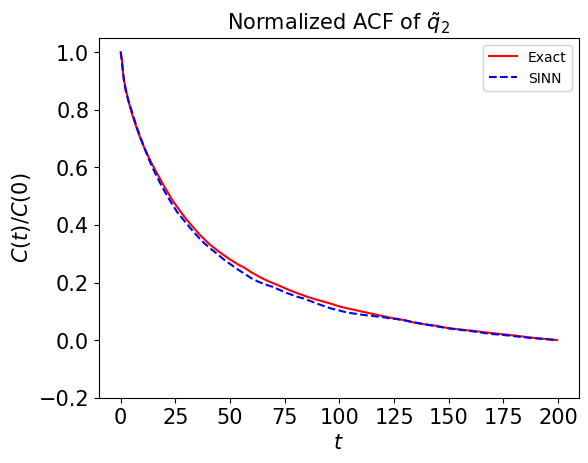

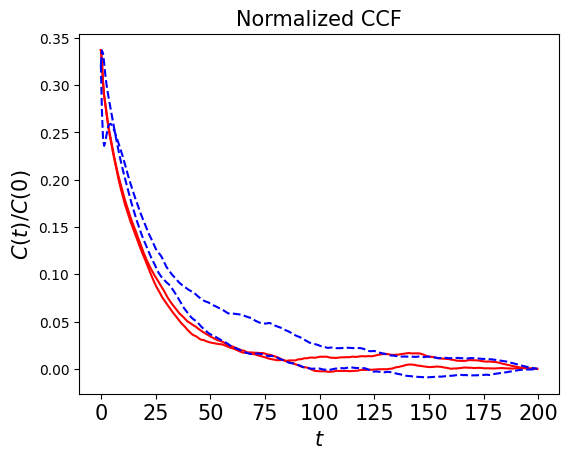

In [35]:
test2(model)

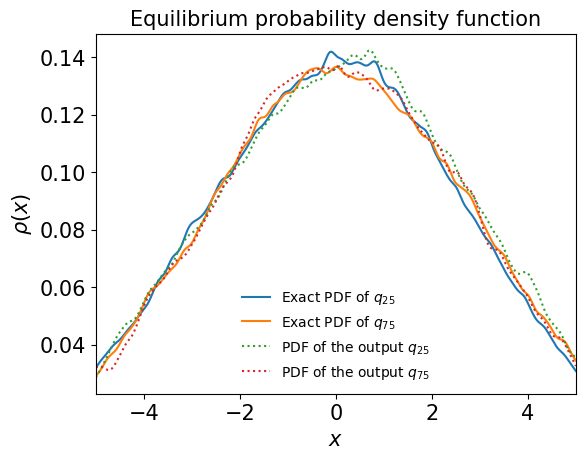

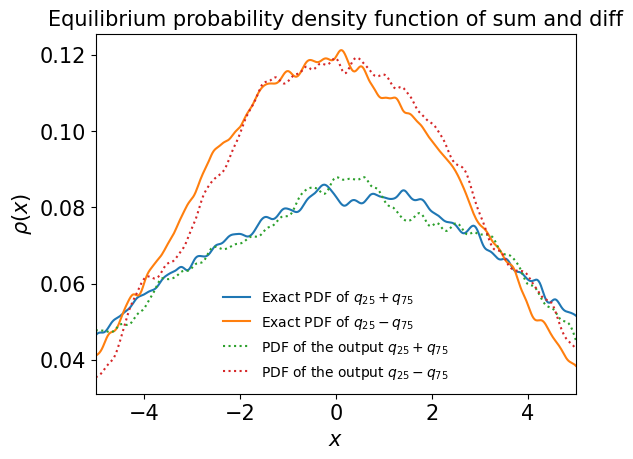

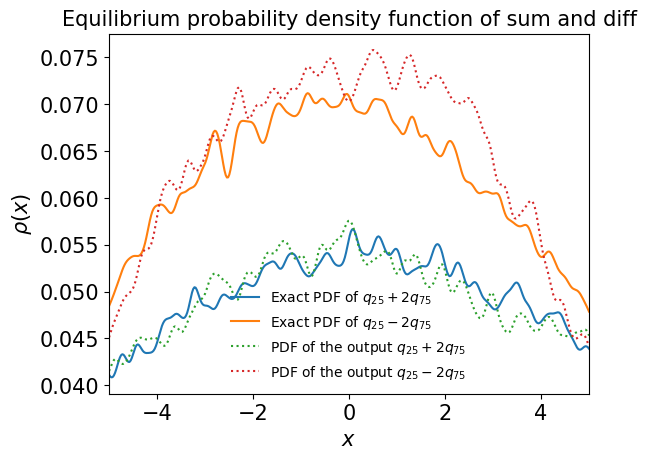

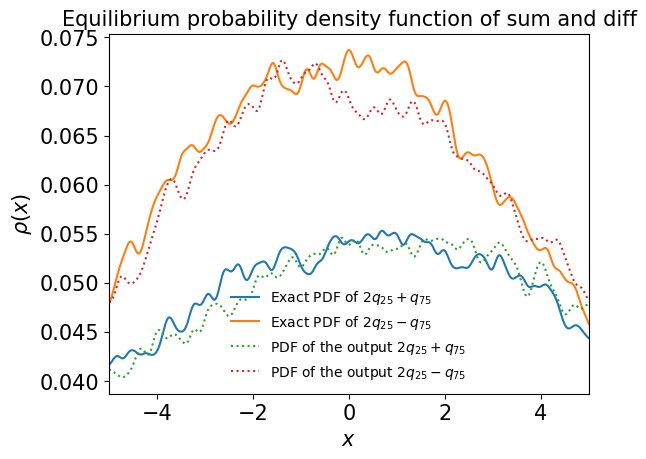

In [36]:
test3(model)

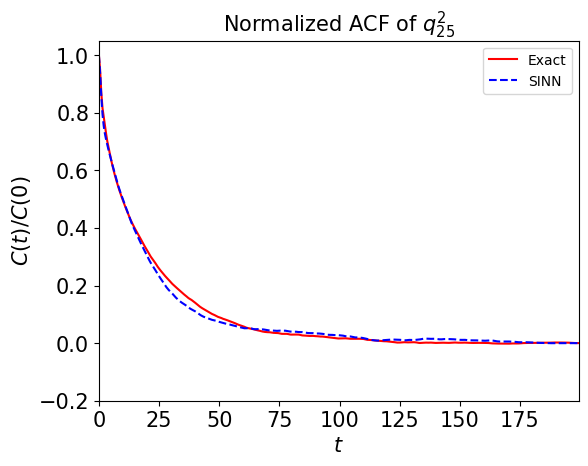

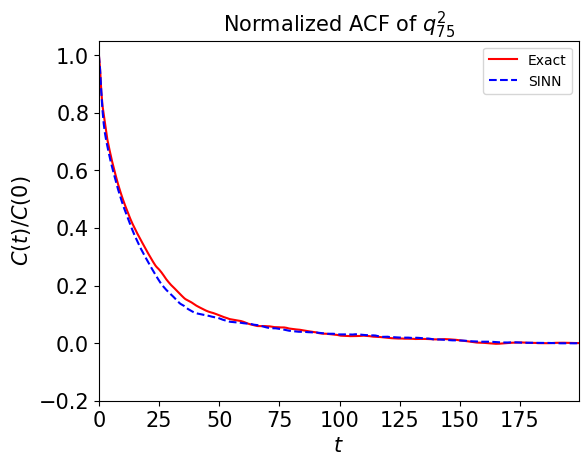

In [37]:
test4(model)

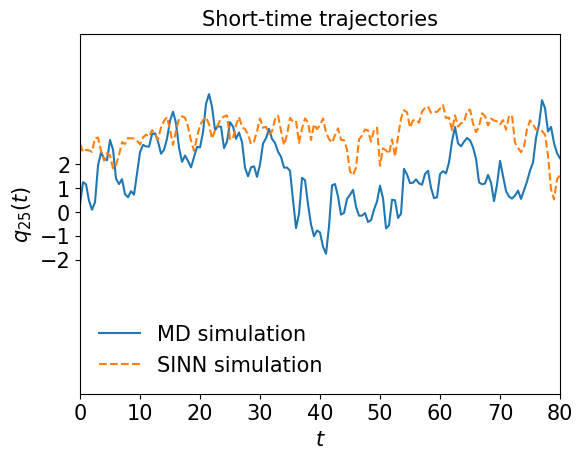

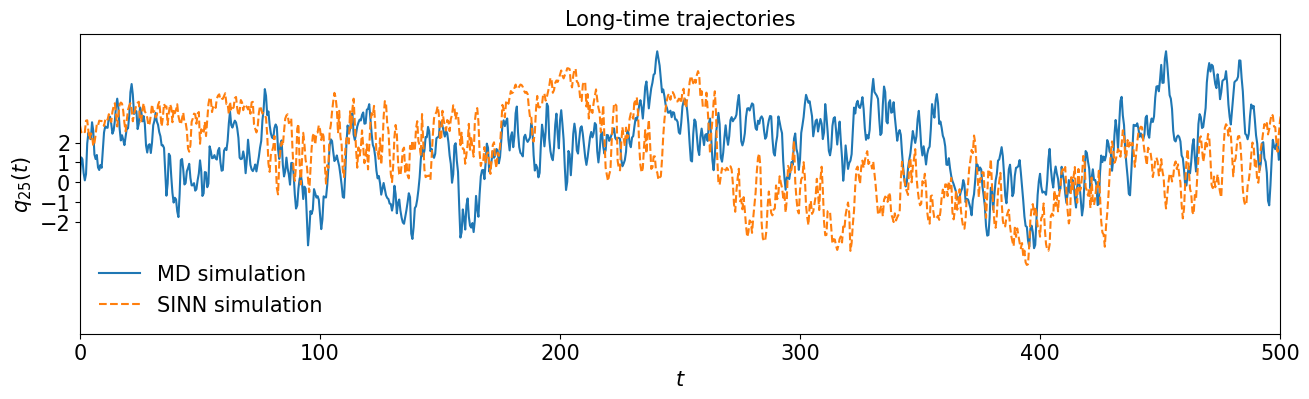

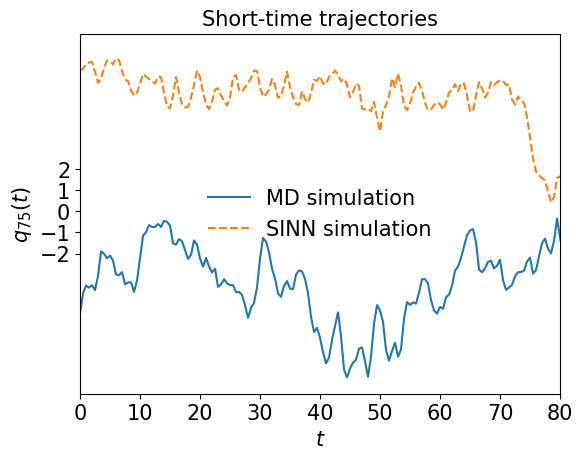

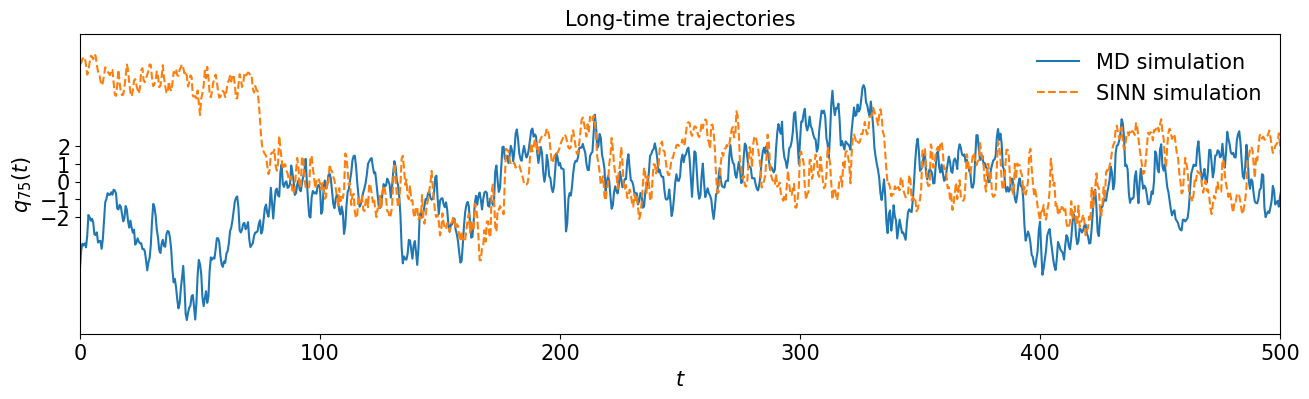

In [38]:
test5(model)

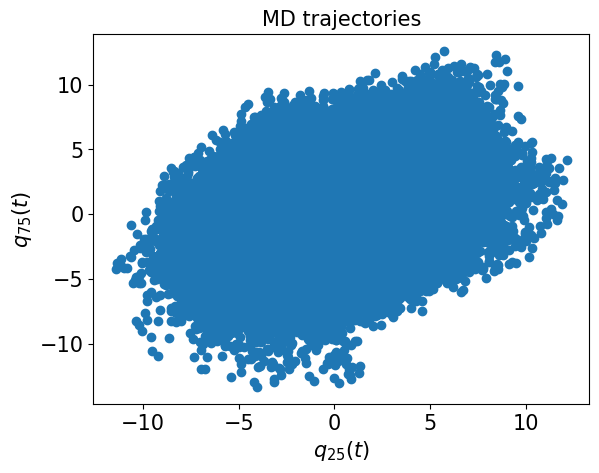

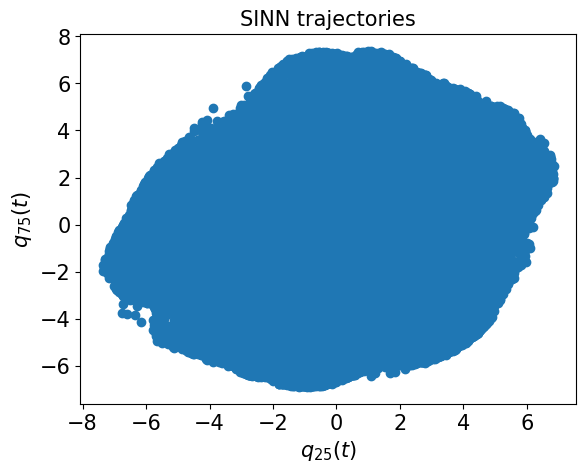

In [39]:
test6(model)

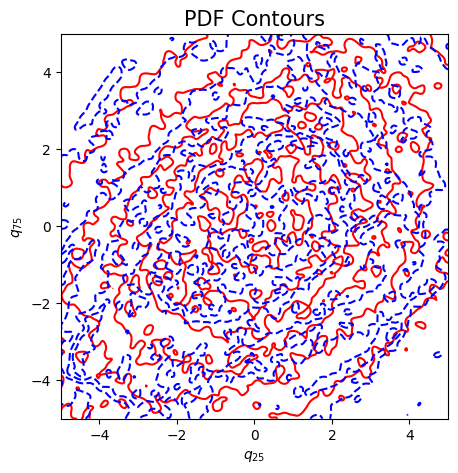

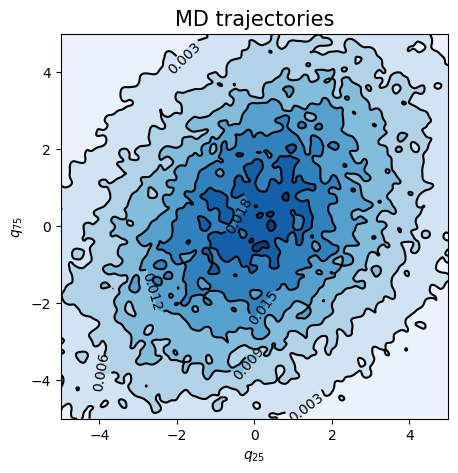

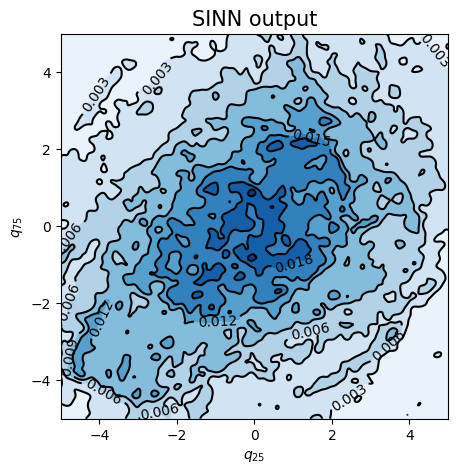

In [40]:
test7(model)

In [41]:
### Defining SINN model
net1 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.7104, 0.6994, acf: 0.07073, ccf: 0.01422, pdf: 0.29105, pdf2: 0.29809, acf2: 0.02535
[50]-th step loss: 0.0563, 0.0717, acf: 0.01479, ccf: 0.01511, pdf: 0.01771, pdf2: 0.01304, acf2: 0.01105
[100]-th step loss: 0.0244, 0.0211, acf: 0.00446, ccf: 0.00050, pdf: 0.00719, pdf2: 0.00165, acf2: 0.00726
[150]-th step loss: 0.0098, 0.0108, acf: 0.00302, ccf: 0.00352, pdf: 0.00259, pdf2: 0.00086, acf2: 0.00078
[200]-th step loss: 0.0132, 0.0206, acf: 0.00046, ccf: 0.00890, pdf: 0.00268, pdf2: 0.00253, acf2: 0.00601
[250]-th step loss: 0.0175, 0.0145, acf: 0.00137, ccf: 0.00171, pdf: 0.00799, pdf2: 0.00174, acf2: 0.00169
[300]-th step loss: 0.0480, 0.0396, acf: 0.01571, ccf: 0.00391, pdf: 0.00969, pdf2: 0.00556, acf2: 0.00468
[350]-th step loss: 0.0122, 0.0117, acf: 0.00373, ccf: 0.00055, pdf: 0.00346, pdf2: 0.00189, acf2: 0.00212
[400]-th step loss: 0.0117, 0.0114, acf: 0.00375, ccf: 0.00394, pdf: 0.00103, pdf2: 0.00090, acf2: 0.00175
[450]-th step loss: 0.0083, 0.0099, acf:

[3850]-th step loss: 0.0004, 0.0010, acf: 0.00011, ccf: 0.00070, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00018
[3900]-th step loss: 0.0005, 0.0010, acf: 0.00015, ccf: 0.00065, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00016
[3950]-th step loss: 0.0009, 0.0013, acf: 0.00021, ccf: 0.00090, pdf: 0.00006, pdf2: 0.00001, acf2: 0.00012
[4000]-th step loss: 0.0007, 0.0007, acf: 0.00016, ccf: 0.00011, pdf: 0.00017, pdf2: 0.00002, acf2: 0.00026
[4050]-th step loss: 0.0010, 0.0016, acf: 0.00014, ccf: 0.00070, pdf: 0.00022, pdf2: 0.00002, acf2: 0.00054
[4100]-th step loss: 0.0011, 0.0010, acf: 0.00020, ccf: 0.00054, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00020
[4150]-th step loss: 0.0009, 0.0012, acf: 0.00011, ccf: 0.00078, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00026
[4200]-th step loss: 0.0005, 0.0009, acf: 0.00017, ccf: 0.00048, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00022
[4250]-th step loss: 0.0010, 0.0009, acf: 0.00009, ccf: 0.00066, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00016
[4300]-th step loss: 0.0011,

In [42]:
### Defining SINN model
net2 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.7070, 0.7035, acf: 0.07189, ccf: 0.01587, pdf: 0.29104, pdf2: 0.29836, acf2: 0.02630
[50]-th step loss: 0.0858, 0.0837, acf: 0.03519, ccf: 0.01744, pdf: 0.01546, pdf2: 0.00842, acf2: 0.00718
[100]-th step loss: 0.0560, 0.0548, acf: 0.01882, ccf: 0.02100, pdf: 0.00736, pdf2: 0.00591, acf2: 0.00168
[150]-th step loss: 0.0384, 0.0344, acf: 0.01617, ccf: 0.01164, pdf: 0.00311, pdf2: 0.00273, acf2: 0.00077
[200]-th step loss: 0.0177, 0.0181, acf: 0.01213, ccf: 0.00150, pdf: 0.00264, pdf2: 0.00101, acf2: 0.00087
[250]-th step loss: 0.0140, 0.0161, acf: 0.00569, ccf: 0.00566, pdf: 0.00239, pdf2: 0.00142, acf2: 0.00090
[300]-th step loss: 0.0556, 0.0529, acf: 0.02741, ccf: 0.01010, pdf: 0.00285, pdf2: 0.00402, acf2: 0.00852
[350]-th step loss: 0.0120, 0.0119, acf: 0.00415, ccf: 0.00142, pdf: 0.00195, pdf2: 0.00027, acf2: 0.00406
[400]-th step loss: 0.0509, 0.0534, acf: 0.00614, ccf: 0.03070, pdf: 0.00645, pdf2: 0.00485, acf2: 0.00523
[450]-th step loss: 0.0239, 0.0240, acf:

[3850]-th step loss: 0.0018, 0.0016, acf: 0.00037, ccf: 0.00064, pdf: 0.00013, pdf2: 0.00002, acf2: 0.00042
[3900]-th step loss: 0.0013, 0.0012, acf: 0.00021, ccf: 0.00067, pdf: 0.00010, pdf2: 0.00002, acf2: 0.00018
[3950]-th step loss: 0.0011, 0.0009, acf: 0.00019, ccf: 0.00034, pdf: 0.00010, pdf2: 0.00003, acf2: 0.00023
[4000]-th step loss: 0.0014, 0.0017, acf: 0.00073, ccf: 0.00025, pdf: 0.00018, pdf2: 0.00002, acf2: 0.00053
[4050]-th step loss: 0.0010, 0.0008, acf: 0.00019, ccf: 0.00024, pdf: 0.00018, pdf2: 0.00002, acf2: 0.00012
[4100]-th step loss: 0.0010, 0.0014, acf: 0.00024, ccf: 0.00021, pdf: 0.00030, pdf2: 0.00007, acf2: 0.00057
[4150]-th step loss: 0.0009, 0.0008, acf: 0.00012, ccf: 0.00015, pdf: 0.00019, pdf2: 0.00002, acf2: 0.00035
[4200]-th step loss: 0.0007, 0.0007, acf: 0.00016, ccf: 0.00019, pdf: 0.00019, pdf2: 0.00004, acf2: 0.00013
[4250]-th step loss: 0.0014, 0.0016, acf: 0.00046, ccf: 0.00018, pdf: 0.00055, pdf2: 0.00011, acf2: 0.00030
[4300]-th step loss: 0.0009,

[7650]-th step loss: 0.0019, 0.0016, acf: 0.00065, ccf: 0.00074, pdf: 0.00007, pdf2: 0.00001, acf2: 0.00017
[7700]-th step loss: 0.0016, 0.0014, acf: 0.00050, ccf: 0.00063, pdf: 0.00011, pdf2: 0.00002, acf2: 0.00013
[7750]-th step loss: 0.0010, 0.0009, acf: 0.00042, ccf: 0.00030, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00015
[7800]-th step loss: 0.0067, 0.0068, acf: 0.00318, ccf: 0.00112, pdf: 0.00060, pdf2: 0.00027, acf2: 0.00167
[7850]-th step loss: 0.0037, 0.0035, acf: 0.00083, ccf: 0.00156, pdf: 0.00043, pdf2: 0.00020, acf2: 0.00045
[7900]-th step loss: 0.0022, 0.0019, acf: 0.00083, ccf: 0.00045, pdf: 0.00024, pdf2: 0.00018, acf2: 0.00017
[7950]-th step loss: 0.0022, 0.0023, acf: 0.00103, ccf: 0.00066, pdf: 0.00018, pdf2: 0.00015, acf2: 0.00025
[8000]-th step loss: 0.0011, 0.0018, acf: 0.00076, ccf: 0.00052, pdf: 0.00012, pdf2: 0.00012, acf2: 0.00026
[8050]-th step loss: 0.0015, 0.0010, acf: 0.00050, ccf: 0.00025, pdf: 0.00007, pdf2: 0.00011, acf2: 0.00010
[8100]-th step loss: 0.0008,

[11450]-th step loss: 0.0008, 0.0007, acf: 0.00031, ccf: 0.00013, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00015
[11500]-th step loss: 0.0005, 0.0006, acf: 0.00029, ccf: 0.00007, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00016
[11550]-th step loss: 0.0011, 0.0020, acf: 0.00043, ccf: 0.00138, pdf: 0.00008, pdf2: 0.00003, acf2: 0.00008
[11600]-th step loss: 0.0017, 0.0008, acf: 0.00026, ccf: 0.00033, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00017
[11650]-th step loss: 0.0014, 0.0009, acf: 0.00020, ccf: 0.00039, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00026
[11700]-th step loss: 0.0007, 0.0012, acf: 0.00043, ccf: 0.00056, pdf: 0.00009, pdf2: 0.00002, acf2: 0.00010
[11750]-th step loss: 0.0007, 0.0009, acf: 0.00028, ccf: 0.00029, pdf: 0.00007, pdf2: 0.00001, acf2: 0.00023
[11800]-th step loss: 0.0008, 0.0008, acf: 0.00012, ccf: 0.00045, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00018
[11850]-th step loss: 0.0009, 0.0005, acf: 0.00019, ccf: 0.00014, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00009
[11900]-th step los

[15250]-th step loss: 0.0039, 0.0038, acf: 0.00123, ccf: 0.00109, pdf: 0.00008, pdf2: 0.00005, acf2: 0.00135
[15300]-th step loss: 0.0030, 0.0034, acf: 0.00136, ccf: 0.00103, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00092
[15350]-th step loss: 0.0023, 0.0032, acf: 0.00066, ccf: 0.00199, pdf: 0.00018, pdf2: 0.00005, acf2: 0.00034
[15400]-th step loss: 0.0024, 0.0025, acf: 0.00058, ccf: 0.00172, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00012
[15450]-th step loss: 0.0015, 0.0025, acf: 0.00094, ccf: 0.00096, pdf: 0.00007, pdf2: 0.00001, acf2: 0.00053
[15500]-th step loss: 0.0028, 0.0027, acf: 0.00077, ccf: 0.00147, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00040
[15550]-th step loss: 0.0020, 0.0020, acf: 0.00056, ccf: 0.00121, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00013
[15600]-th step loss: 0.0011, 0.0017, acf: 0.00050, ccf: 0.00079, pdf: 0.00007, pdf2: 0.00003, acf2: 0.00028
[15650]-th step loss: 0.0016, 0.0016, acf: 0.00059, ccf: 0.00040, pdf: 0.00021, pdf2: 0.00005, acf2: 0.00031
[15700]-th step los

In [43]:
### Defining SINN model
net3 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.7004, 0.6929, acf: 0.07177, ccf: 0.00568, pdf: 0.29117, pdf2: 0.29831, acf2: 0.02597
[50]-th step loss: 0.0931, 0.0960, acf: 0.04048, ccf: 0.01651, pdf: 0.01001, pdf2: 0.01890, acf2: 0.01008
[100]-th step loss: 0.0569, 0.0557, acf: 0.01194, ccf: 0.02674, pdf: 0.00364, pdf2: 0.00892, acf2: 0.00443
[150]-th step loss: 0.0723, 0.0704, acf: 0.03506, ccf: 0.01670, pdf: 0.00464, pdf2: 0.00745, acf2: 0.00657
[200]-th step loss: 0.0402, 0.0395, acf: 0.01535, ccf: 0.01634, pdf: 0.00086, pdf2: 0.00516, acf2: 0.00182
[250]-th step loss: 0.0377, 0.0396, acf: 0.01667, ccf: 0.01583, pdf: 0.00161, pdf2: 0.00421, acf2: 0.00131
[300]-th step loss: 0.0389, 0.0366, acf: 0.01523, ccf: 0.01627, pdf: 0.00090, pdf2: 0.00326, acf2: 0.00091
[350]-th step loss: 0.0456, 0.0446, acf: 0.02585, ccf: 0.01224, pdf: 0.00156, pdf2: 0.00268, acf2: 0.00228
[400]-th step loss: 0.0973, 0.0880, acf: 0.04365, ccf: 0.00623, pdf: 0.01069, pdf2: 0.01967, acf2: 0.00779
[450]-th step loss: 0.0356, 0.0329, acf:

[3850]-th step loss: 0.0142, 0.0154, acf: 0.00745, ccf: 0.00069, pdf: 0.00532, pdf2: 0.00183, acf2: 0.00007
[3900]-th step loss: 0.0169, 0.0178, acf: 0.00978, ccf: 0.00025, pdf: 0.00585, pdf2: 0.00181, acf2: 0.00015
[3950]-th step loss: 0.0150, 0.0165, acf: 0.00860, ccf: 0.00062, pdf: 0.00538, pdf2: 0.00183, acf2: 0.00005
[4000]-th step loss: 0.0138, 0.0162, acf: 0.00841, ccf: 0.00045, pdf: 0.00544, pdf2: 0.00181, acf2: 0.00005
[4050]-th step loss: 0.0160, 0.0167, acf: 0.00878, ccf: 0.00047, pdf: 0.00553, pdf2: 0.00178, acf2: 0.00010
[4100]-th step loss: 0.0161, 0.0149, acf: 0.00728, ccf: 0.00019, pdf: 0.00550, pdf2: 0.00184, acf2: 0.00012
[4150]-th step loss: 0.0162, 0.0173, acf: 0.00968, ccf: 0.00040, pdf: 0.00514, pdf2: 0.00196, acf2: 0.00010
[4200]-th step loss: 0.0148, 0.0148, acf: 0.00713, ccf: 0.00040, pdf: 0.00517, pdf2: 0.00199, acf2: 0.00016
[4250]-th step loss: 0.0185, 0.0166, acf: 0.00869, ccf: 0.00056, pdf: 0.00545, pdf2: 0.00183, acf2: 0.00010
[4300]-th step loss: 0.0145,

[7650]-th step loss: 0.0150, 0.0162, acf: 0.00889, ccf: 0.00010, pdf: 0.00534, pdf2: 0.00179, acf2: 0.00006
[7700]-th step loss: 0.0146, 0.0161, acf: 0.00877, ccf: 0.00007, pdf: 0.00529, pdf2: 0.00186, acf2: 0.00007
[7750]-th step loss: 0.0162, 0.0176, acf: 0.00989, ccf: 0.00010, pdf: 0.00577, pdf2: 0.00175, acf2: 0.00012
[7800]-th step loss: 0.0163, 0.0173, acf: 0.00945, ccf: 0.00033, pdf: 0.00567, pdf2: 0.00175, acf2: 0.00008
[7850]-th step loss: 0.0157, 0.0164, acf: 0.00893, ccf: 0.00011, pdf: 0.00554, pdf2: 0.00175, acf2: 0.00006
[7900]-th step loss: 0.0143, 0.0154, acf: 0.00803, ccf: 0.00006, pdf: 0.00548, pdf2: 0.00175, acf2: 0.00007
[7950]-th step loss: 0.0159, 0.0162, acf: 0.00869, ccf: 0.00019, pdf: 0.00551, pdf2: 0.00171, acf2: 0.00007
[8000]-th step loss: 0.0162, 0.0172, acf: 0.00949, ccf: 0.00016, pdf: 0.00529, pdf2: 0.00187, acf2: 0.00041
[8050]-th step loss: 0.0156, 0.0181, acf: 0.01055, ccf: 0.00014, pdf: 0.00532, pdf2: 0.00180, acf2: 0.00026
[8100]-th step loss: 0.0163,

[11450]-th step loss: 0.0150, 0.0158, acf: 0.00884, ccf: 0.00014, pdf: 0.00511, pdf2: 0.00164, acf2: 0.00007
[11500]-th step loss: 0.0158, 0.0152, acf: 0.00825, ccf: 0.00008, pdf: 0.00506, pdf2: 0.00170, acf2: 0.00008
[11550]-th step loss: 0.0179, 0.0168, acf: 0.00952, ccf: 0.00013, pdf: 0.00538, pdf2: 0.00164, acf2: 0.00009
[11600]-th step loss: 0.0138, 0.0147, acf: 0.00758, ccf: 0.00014, pdf: 0.00528, pdf2: 0.00160, acf2: 0.00008
[11650]-th step loss: 0.0161, 0.0151, acf: 0.00834, ccf: 0.00004, pdf: 0.00505, pdf2: 0.00162, acf2: 0.00006
[11700]-th step loss: 0.0157, 0.0171, acf: 0.00941, ccf: 0.00011, pdf: 0.00592, pdf2: 0.00152, acf2: 0.00015
[11750]-th step loss: 0.0142, 0.0154, acf: 0.00843, ccf: 0.00030, pdf: 0.00500, pdf2: 0.00158, acf2: 0.00006
[11800]-th step loss: 0.0149, 0.0153, acf: 0.00838, ccf: 0.00010, pdf: 0.00520, pdf2: 0.00157, acf2: 0.00009
[11850]-th step loss: 0.0158, 0.0166, acf: 0.00903, ccf: 0.00010, pdf: 0.00579, pdf2: 0.00161, acf2: 0.00006
[11900]-th step los

[15250]-th step loss: 0.0025, 0.0013, acf: 0.00057, ccf: 0.00014, pdf: 0.00012, pdf2: 0.00002, acf2: 0.00041
[15300]-th step loss: 0.0008, 0.0006, acf: 0.00021, ccf: 0.00013, pdf: 0.00010, pdf2: 0.00001, acf2: 0.00019
[15350]-th step loss: 0.0006, 0.0006, acf: 0.00017, ccf: 0.00010, pdf: 0.00018, pdf2: 0.00004, acf2: 0.00017
[15400]-th step loss: 0.0007, 0.0015, acf: 0.00032, ccf: 0.00071, pdf: 0.00009, pdf2: 0.00007, acf2: 0.00030
[15450]-th step loss: 0.0011, 0.0004, acf: 0.00007, ccf: 0.00016, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00013
[15500]-th step loss: 0.0007, 0.0006, acf: 0.00014, ccf: 0.00025, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00017
[15550]-th step loss: 0.0008, 0.0011, acf: 0.00032, ccf: 0.00050, pdf: 0.00008, pdf2: 0.00004, acf2: 0.00019
[15600]-th step loss: 0.0007, 0.0010, acf: 0.00032, ccf: 0.00047, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00012
[15650]-th step loss: 0.0015, 0.0010, acf: 0.00046, ccf: 0.00025, pdf: 0.00009, pdf2: 0.00003, acf2: 0.00017
[15700]-th step los

In [44]:
### Defining SINN model
net4 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.6963, 0.6915, acf: 0.07107, ccf: 0.00567, pdf: 0.29102, pdf2: 0.29824, acf2: 0.02552
[50]-th step loss: 0.0847, 0.0855, acf: 0.02501, ccf: 0.02235, pdf: 0.02025, pdf2: 0.01148, acf2: 0.00642
[100]-th step loss: 0.0579, 0.0552, acf: 0.00930, ccf: 0.02683, pdf: 0.00829, pdf2: 0.00637, acf2: 0.00437
[150]-th step loss: 0.0499, 0.0515, acf: 0.01298, ccf: 0.02285, pdf: 0.00692, pdf2: 0.00361, acf2: 0.00514
[200]-th step loss: 0.0477, 0.0449, acf: 0.01242, ccf: 0.02175, pdf: 0.00402, pdf2: 0.00256, acf2: 0.00411
[250]-th step loss: 0.0446, 0.0448, acf: 0.01355, ccf: 0.02137, pdf: 0.00622, pdf2: 0.00210, acf2: 0.00155
[300]-th step loss: 0.0375, 0.0377, acf: 0.01376, ccf: 0.01531, pdf: 0.00494, pdf2: 0.00243, acf2: 0.00129
[350]-th step loss: 0.0410, 0.0395, acf: 0.01829, ccf: 0.00882, pdf: 0.00725, pdf2: 0.00273, acf2: 0.00238
[400]-th step loss: 0.0318, 0.0308, acf: 0.01062, ccf: 0.01419, pdf: 0.00315, pdf2: 0.00084, acf2: 0.00196
[450]-th step loss: 0.0464, 0.0471, acf:

[3850]-th step loss: 0.0327, 0.0295, acf: 0.02806, ccf: 0.00082, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00059
[3900]-th step loss: 0.0409, 0.0325, acf: 0.03161, ccf: 0.00042, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00043
[3950]-th step loss: 0.0342, 0.0306, acf: 0.02854, ccf: 0.00146, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00057
[4000]-th step loss: 0.0363, 0.0342, acf: 0.03340, ccf: 0.00035, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00040
[4050]-th step loss: 0.0362, 0.0332, acf: 0.03262, ccf: 0.00025, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00027
[4100]-th step loss: 0.0362, 0.0307, acf: 0.02999, ccf: 0.00025, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00041
[4150]-th step loss: 0.0307, 0.0294, acf: 0.02767, ccf: 0.00099, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00067
[4200]-th step loss: 0.0368, 0.0300, acf: 0.02880, ccf: 0.00067, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00054
[4250]-th step loss: 0.0343, 0.0310, acf: 0.03006, ccf: 0.00054, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00038
[4300]-th step loss: 0.0352,

[7650]-th step loss: 0.0165, 0.0169, acf: 0.01662, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00011
[7700]-th step loss: 0.0169, 0.0155, acf: 0.01513, ccf: 0.00021, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00015
[7750]-th step loss: 0.0161, 0.0156, acf: 0.01495, ccf: 0.00042, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00018
[7800]-th step loss: 0.0163, 0.0166, acf: 0.01629, ccf: 0.00016, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00015
[7850]-th step loss: 0.0157, 0.0159, acf: 0.01553, ccf: 0.00023, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00012
[7900]-th step loss: 0.0167, 0.0164, acf: 0.01617, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00007
[7950]-th step loss: 0.0154, 0.0158, acf: 0.01539, ccf: 0.00028, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00013
[8000]-th step loss: 0.0158, 0.0165, acf: 0.01618, ccf: 0.00018, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00009
[8050]-th step loss: 0.0172, 0.0173, acf: 0.01713, ccf: 0.00015, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00005
[8100]-th step loss: 0.0160,

[11450]-th step loss: 0.0093, 0.0105, acf: 0.01022, ccf: 0.00010, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00013
[11500]-th step loss: 0.0131, 0.0113, acf: 0.01095, ccf: 0.00008, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00022
[11550]-th step loss: 0.0089, 0.0109, acf: 0.01048, ccf: 0.00008, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00026
[11600]-th step loss: 0.0120, 0.0110, acf: 0.01088, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00009
[11650]-th step loss: 0.0143, 0.0141, acf: 0.01359, ccf: 0.00007, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00039
[11700]-th step loss: 0.0121, 0.0114, acf: 0.01118, ccf: 0.00009, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00015
[11750]-th step loss: 0.0116, 0.0142, acf: 0.01383, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00029
[11800]-th step loss: 0.0143, 0.0121, acf: 0.01195, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00012
[11850]-th step loss: 0.0131, 0.0123, acf: 0.01165, ccf: 0.00012, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00043
[11900]-th step los

[15250]-th step loss: 0.0027, 0.0032, acf: 0.00267, ccf: 0.00010, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00035
[15300]-th step loss: 0.0016, 0.0038, acf: 0.00343, ccf: 0.00005, pdf: 0.00007, pdf2: 0.00003, acf2: 0.00020
[15350]-th step loss: 0.0015, 0.0027, acf: 0.00211, ccf: 0.00020, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00038
[15400]-th step loss: 0.0018, 0.0027, acf: 0.00213, ccf: 0.00022, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00029
[15450]-th step loss: 0.0014, 0.0018, acf: 0.00156, ccf: 0.00011, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00015
[15500]-th step loss: 0.0008, 0.0014, acf: 0.00091, ccf: 0.00010, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00034
[15550]-th step loss: 0.0008, 0.0011, acf: 0.00063, ccf: 0.00021, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00022
[15600]-th step loss: 0.0010, 0.0010, acf: 0.00084, ccf: 0.00008, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00005
[15650]-th step loss: 0.0007, 0.0009, acf: 0.00067, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00015
[15700]-th step los

In [45]:
### Defining SINN model
net5 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.6917, 0.7011, acf: 0.07045, ccf: 0.01619, pdf: 0.29115, pdf2: 0.29831, acf2: 0.02505
[50]-th step loss: 0.0910, 0.0907, acf: 0.04130, ccf: 0.01585, pdf: 0.00792, pdf2: 0.01426, acf2: 0.01136
[100]-th step loss: 0.0544, 0.0553, acf: 0.01088, ccf: 0.03087, pdf: 0.00363, pdf2: 0.00847, acf2: 0.00141
[150]-th step loss: 0.0433, 0.0418, acf: 0.00612, ccf: 0.02650, pdf: 0.00210, pdf2: 0.00562, acf2: 0.00143
[200]-th step loss: 0.0748, 0.0704, acf: 0.03647, ccf: 0.01248, pdf: 0.00387, pdf2: 0.00931, acf2: 0.00824
[250]-th step loss: 0.0410, 0.0395, acf: 0.01350, ccf: 0.01977, pdf: 0.00047, pdf2: 0.00425, acf2: 0.00152
[300]-th step loss: 0.0572, 0.1417, acf: 0.06165, ccf: 0.00493, pdf: 0.02781, pdf2: 0.03290, acf2: 0.01440
[350]-th step loss: 0.0451, 0.0496, acf: 0.02530, ccf: 0.01028, pdf: 0.00263, pdf2: 0.00885, acf2: 0.00256
[400]-th step loss: 0.0358, 0.0360, acf: 0.01168, ccf: 0.01856, pdf: 0.00123, pdf2: 0.00305, acf2: 0.00148
[450]-th step loss: 0.0342, 0.0342, acf:

[3850]-th step loss: 0.0117, 0.0126, acf: 0.01223, ccf: 0.00018, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00022
[3900]-th step loss: 0.0100, 0.0110, acf: 0.01075, ccf: 0.00012, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00014
[3950]-th step loss: 0.0165, 0.0118, acf: 0.01155, ccf: 0.00015, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00010
[4000]-th step loss: 0.0114, 0.0123, acf: 0.01209, ccf: 0.00009, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00009
[4050]-th step loss: 0.0099, 0.0095, acf: 0.00908, ccf: 0.00013, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00024
[4100]-th step loss: 0.0126, 0.0122, acf: 0.01172, ccf: 0.00012, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00038
[4150]-th step loss: 0.0128, 0.0122, acf: 0.01167, ccf: 0.00017, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00034
[4200]-th step loss: 0.0088, 0.0122, acf: 0.01138, ccf: 0.00027, pdf: 0.00002, pdf2: 0.00000, acf2: 0.00056
[4250]-th step loss: 0.0077, 0.0108, acf: 0.01018, ccf: 0.00020, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00045
[4300]-th step loss: 0.0119,

In [46]:
### Defining SINN model
net6 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

[0]-th step loss: 0.6956, 0.6939, acf: 0.07191, ccf: 0.00647, pdf: 0.29113, pdf2: 0.29829, acf2: 0.02611
[50]-th step loss: 0.0881, 0.0879, acf: 0.03752, ccf: 0.01691, pdf: 0.01036, pdf2: 0.01553, acf2: 0.00754
[100]-th step loss: 0.0553, 0.0571, acf: 0.01514, ccf: 0.02814, pdf: 0.00291, pdf2: 0.00761, acf2: 0.00331
[150]-th step loss: 0.0495, 0.0477, acf: 0.01932, ccf: 0.01822, pdf: 0.00305, pdf2: 0.00627, acf2: 0.00085
[200]-th step loss: 0.0851, 0.0853, acf: 0.02169, ccf: 0.00326, pdf: 0.03889, pdf2: 0.01984, acf2: 0.00163
[250]-th step loss: 0.0366, 0.0343, acf: 0.01013, ccf: 0.00086, pdf: 0.01446, pdf2: 0.00690, acf2: 0.00196
[300]-th step loss: 0.0234, 0.0233, acf: 0.00465, ccf: 0.00289, pdf: 0.00897, pdf2: 0.00477, acf2: 0.00200
[350]-th step loss: 0.0177, 0.0183, acf: 0.00088, ccf: 0.00056, pdf: 0.00691, pdf2: 0.00366, acf2: 0.00631
[400]-th step loss: 0.0167, 0.0181, acf: 0.00153, ccf: 0.00180, pdf: 0.00700, pdf2: 0.00379, acf2: 0.00393
[450]-th step loss: 0.0235, 0.0160, acf:

[3850]-th step loss: 0.0271, 0.0308, acf: 0.03030, ccf: 0.00022, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00026
[3900]-th step loss: 0.0490, 0.0452, acf: 0.04195, ccf: 0.00062, pdf: 0.00131, pdf2: 0.00019, acf2: 0.00109
[3950]-th step loss: 0.0435, 0.0456, acf: 0.04281, ccf: 0.00073, pdf: 0.00041, pdf2: 0.00020, acf2: 0.00141
[4000]-th step loss: 0.0456, 0.0394, acf: 0.03858, ccf: 0.00031, pdf: 0.00008, pdf2: 0.00005, acf2: 0.00041
[4050]-th step loss: 0.0857, 0.0759, acf: 0.00124, ccf: 0.04007, pdf: 0.00177, pdf2: 0.00070, acf2: 0.03213
[4100]-th step loss: 0.0221, 0.0203, acf: 0.01472, ccf: 0.00356, pdf: 0.00034, pdf2: 0.00017, acf2: 0.00156
[4150]-th step loss: 0.0171, 0.0166, acf: 0.01357, ccf: 0.00148, pdf: 0.00014, pdf2: 0.00006, acf2: 0.00139
[4200]-th step loss: 0.0127, 0.0132, acf: 0.01037, ccf: 0.00114, pdf: 0.00010, pdf2: 0.00002, acf2: 0.00153
[4250]-th step loss: 0.0135, 0.0117, acf: 0.00759, ccf: 0.00176, pdf: 0.00014, pdf2: 0.00004, acf2: 0.00216
[4300]-th step loss: 0.0483,

[7650]-th step loss: 0.0051, 0.0064, acf: 0.00142, ccf: 0.00100, pdf: 0.00034, pdf2: 0.00030, acf2: 0.00338
[7700]-th step loss: 0.0039, 0.0046, acf: 0.00183, ccf: 0.00072, pdf: 0.00021, pdf2: 0.00014, acf2: 0.00167
[7750]-th step loss: 0.1668, 0.1650, acf: 0.06782, ccf: 0.00359, pdf: 0.00397, pdf2: 0.00256, acf2: 0.08708
[7800]-th step loss: 0.0634, 0.0568, acf: 0.03689, ccf: 0.00511, pdf: 0.00624, pdf2: 0.00343, acf2: 0.00517
[7850]-th step loss: 0.0292, 0.0277, acf: 0.01271, ccf: 0.00342, pdf: 0.00515, pdf2: 0.00230, acf2: 0.00417
[7900]-th step loss: 0.0197, 0.0180, acf: 0.00523, ccf: 0.00121, pdf: 0.00555, pdf2: 0.00243, acf2: 0.00362
[7950]-th step loss: 0.0159, 0.0149, acf: 0.00392, ccf: 0.00087, pdf: 0.00454, pdf2: 0.00204, acf2: 0.00358
[8000]-th step loss: 0.0130, 0.0148, acf: 0.00457, ccf: 0.00060, pdf: 0.00407, pdf2: 0.00185, acf2: 0.00375
[8050]-th step loss: 0.0209, 0.0213, acf: 0.00349, ccf: 0.00577, pdf: 0.00571, pdf2: 0.00201, acf2: 0.00435
[8100]-th step loss: 0.0125,

[11450]-th step loss: 0.0014, 0.0008, acf: 0.00021, ccf: 0.00029, pdf: 0.00006, pdf2: 0.00003, acf2: 0.00021
[11500]-th step loss: 0.0026, 0.0024, acf: 0.00112, ccf: 0.00042, pdf: 0.00023, pdf2: 0.00005, acf2: 0.00059
[11550]-th step loss: 0.0008, 0.0009, acf: 0.00032, ccf: 0.00005, pdf: 0.00029, pdf2: 0.00004, acf2: 0.00022
[11600]-th step loss: 0.0015, 0.0011, acf: 0.00028, ccf: 0.00029, pdf: 0.00013, pdf2: 0.00006, acf2: 0.00038
[11650]-th step loss: 0.0009, 0.0013, acf: 0.00047, ccf: 0.00032, pdf: 0.00007, pdf2: 0.00002, acf2: 0.00038
[11700]-th step loss: 0.0018, 0.0023, acf: 0.00022, ccf: 0.00166, pdf: 0.00003, pdf2: 0.00003, acf2: 0.00040
[11750]-th step loss: 0.0011, 0.0006, acf: 0.00021, ccf: 0.00013, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00020
[11800]-th step loss: 0.0036, 0.0013, acf: 0.00019, ccf: 0.00079, pdf: 0.00006, pdf2: 0.00002, acf2: 0.00023
[11850]-th step loss: 0.0008, 0.0013, acf: 0.00019, ccf: 0.00089, pdf: 0.00003, pdf2: 0.00004, acf2: 0.00013
[11900]-th step los

In [47]:
### Defining SINN model
net7 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

[0]-th step loss: 0.6920, 0.6957, acf: 0.06919, ccf: 0.01309, pdf: 0.29102, pdf2: 0.29826, acf2: 0.02414
[50]-th step loss: 0.0897, 0.0845, acf: 0.01912, ccf: 0.02632, pdf: 0.02400, pdf2: 0.01164, acf2: 0.00346
[100]-th step loss: 0.0665, 0.0636, acf: 0.00915, ccf: 0.02403, pdf: 0.01765, pdf2: 0.00896, acf2: 0.00382
[150]-th step loss: 0.0875, 0.0871, acf: 0.02976, ccf: 0.01621, pdf: 0.02282, pdf2: 0.01507, acf2: 0.00327
[200]-th step loss: 0.0422, 0.0396, acf: 0.01375, ccf: 0.01521, pdf: 0.00592, pdf2: 0.00271, acf2: 0.00205
[250]-th step loss: 0.0320, 0.0307, acf: 0.01985, ccf: 0.00657, pdf: 0.00179, pdf2: 0.00143, acf2: 0.00103
[300]-th step loss: 0.0333, 0.0343, acf: 0.00734, ccf: 0.00719, pdf: 0.01469, pdf2: 0.00314, acf2: 0.00198
[350]-th step loss: 0.0560, 0.0539, acf: 0.00389, ccf: 0.03496, pdf: 0.00828, pdf2: 0.00421, acf2: 0.00257
[400]-th step loss: 0.0374, 0.0358, acf: 0.00906, ccf: 0.01782, pdf: 0.00705, pdf2: 0.00136, acf2: 0.00049
[450]-th step loss: 0.0252, 0.0237, acf:

In [48]:
### Defining SINN model
net8 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

[0]-th step loss: 0.6983, 0.6921, acf: 0.07090, ccf: 0.00630, pdf: 0.29107, pdf2: 0.29823, acf2: 0.02557
[50]-th step loss: 0.0892, 0.0865, acf: 0.03940, ccf: 0.01605, pdf: 0.00734, pdf2: 0.01473, acf2: 0.00897
[100]-th step loss: 0.0502, 0.0670, acf: 0.00252, ccf: 0.04206, pdf: 0.00413, pdf2: 0.00715, acf2: 0.01111
[150]-th step loss: 0.0562, 0.0536, acf: 0.01661, ccf: 0.02027, pdf: 0.00529, pdf2: 0.00890, acf2: 0.00251
[200]-th step loss: 0.0577, 0.0444, acf: 0.00473, ccf: 0.03025, pdf: 0.00318, pdf2: 0.00526, acf2: 0.00097
[250]-th step loss: 0.3072, 0.3131, acf: 0.03728, ccf: 0.01114, pdf: 0.15590, pdf2: 0.10298, acf2: 0.00577
[300]-th step loss: 0.2849, 0.2844, acf: 0.01516, ccf: 0.01343, pdf: 0.15081, pdf2: 0.10359, acf2: 0.00146
[350]-th step loss: 0.1844, 0.1841, acf: 0.01511, ccf: 0.01276, pdf: 0.15050, pdf2: 0.00438, acf2: 0.00135
[400]-th step loss: 0.1797, 0.1795, acf: 0.01201, ccf: 0.01173, pdf: 0.15002, pdf2: 0.00438, acf2: 0.00141
[450]-th step loss: 0.1782, 0.1682, acf:

[3850]-th step loss: 0.0006, 0.0008, acf: 0.00011, ccf: 0.00050, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00008
[3900]-th step loss: 0.0019, 0.0005, acf: 0.00020, ccf: 0.00013, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00010
[3950]-th step loss: 0.0007, 0.0004, acf: 0.00012, ccf: 0.00012, pdf: 0.00005, pdf2: 0.00004, acf2: 0.00006
[4000]-th step loss: 0.0004, 0.0008, acf: 0.00042, ccf: 0.00021, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00010
[4050]-th step loss: 0.0015, 0.0008, acf: 0.00022, ccf: 0.00039, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00015
[4100]-th step loss: 0.0004, 0.0006, acf: 0.00011, ccf: 0.00011, pdf: 0.00021, pdf2: 0.00007, acf2: 0.00008
[4150]-th step loss: 0.0004, 0.0005, acf: 0.00011, ccf: 0.00024, pdf: 0.00004, pdf2: 0.00003, acf2: 0.00011
[4200]-th step loss: 0.0005, 0.0005, acf: 0.00006, ccf: 0.00031, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00009
Training finished
Training time: 404.41
Training time per iteration: 0.10
Number of Iterations:4201


In [49]:
### Defining SINN model
net9 = SINN(2, 75, 3, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

[0]-th step loss: 0.6972, 0.6911, acf: 0.07111, ccf: 0.00508, pdf: 0.29104, pdf2: 0.29828, acf2: 0.02558
[50]-th step loss: 0.1978, 0.0787, acf: 0.02919, ccf: 0.01801, pdf: 0.01112, pdf2: 0.01712, acf2: 0.00327
[100]-th step loss: 0.0552, 0.0550, acf: 0.00529, ccf: 0.03426, pdf: 0.00447, pdf2: 0.00854, acf2: 0.00246
[150]-th step loss: 0.0393, 0.0412, acf: 0.01281, ccf: 0.01716, pdf: 0.00379, pdf2: 0.00549, acf2: 0.00192
[200]-th step loss: 0.0269, 0.0347, acf: 0.00903, ccf: 0.00210, pdf: 0.00571, pdf2: 0.00304, acf2: 0.01485
[250]-th step loss: 0.0443, 0.0451, acf: 0.01700, ccf: 0.01324, pdf: 0.00207, pdf2: 0.00309, acf2: 0.00966
[300]-th step loss: 0.0892, 0.0938, acf: 0.05144, ccf: 0.01042, pdf: 0.01101, pdf2: 0.00587, acf2: 0.01506
[350]-th step loss: 0.0452, 0.0480, acf: 0.02130, ccf: 0.01718, pdf: 0.00473, pdf2: 0.00279, acf2: 0.00204
[400]-th step loss: 0.0459, 0.0442, acf: 0.02294, ccf: 0.00500, pdf: 0.00888, pdf2: 0.00178, acf2: 0.00558
[450]-th step loss: 0.0530, 0.0535, acf: